In [1]:
import pandas as pd
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from model.tank_model import tank_model_Q2_impervious_area as tank_model
from bayes_opt import BayesianOptimization


# Trend detect

In [2]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
discharge = fengqiao['discharge']
precipitation = fengqiao['precipitation']
et = mete['ETo_PM']

In [4]:
suzhou = pd.read_csv('../data/intermediate/suzhou_interpolated.csv', index_col=0, parse_dates=True)
water_level = suzhou['water_level']

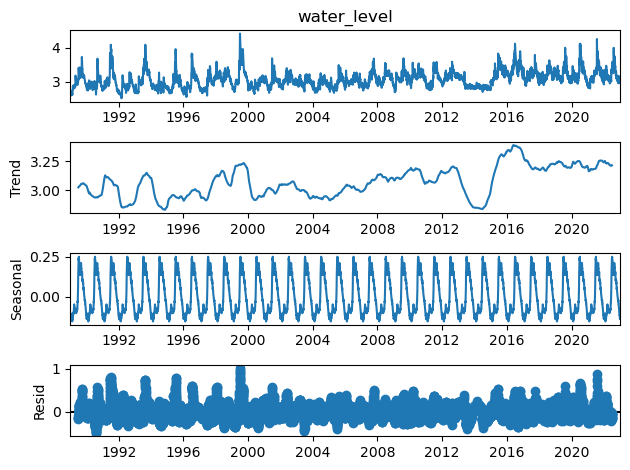

In [6]:
# 对数据进行季节性分解，设置freq为365
wl_result = seasonal_decompose(water_level, model='additive', period=365)

# 绘制分解结果
wl_result.plot()
plt.show()

# 获取趋势部分
wl_trend = wl_result.trend

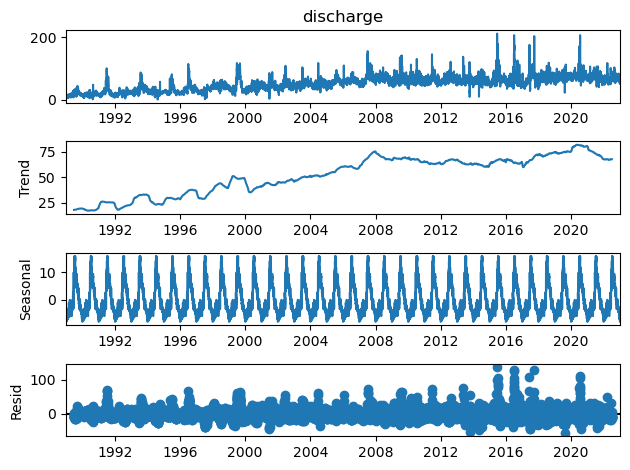

In [3]:
# 对数据进行季节性分解，设置freq为365
discharge_result = seasonal_decompose(discharge, model='additive', period=365)

# 绘制分解结果
discharge_result.plot()
plt.show()

# 获取趋势部分
discharge_trend = discharge_result.trend

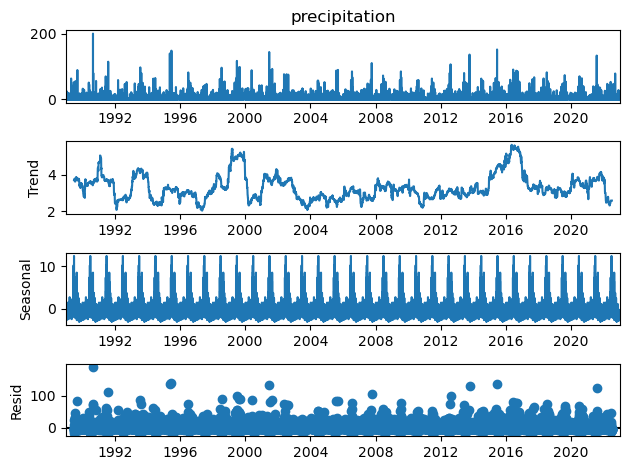

In [4]:
# 对数据进行季节性分解，设置freq为365
precipitation_result = seasonal_decompose(precipitation, model='additive', period=365)

# 绘制分解结果
precipitation_result.plot()
plt.show()

# 获取趋势部分
precipitation_trend = precipitation_result.trend

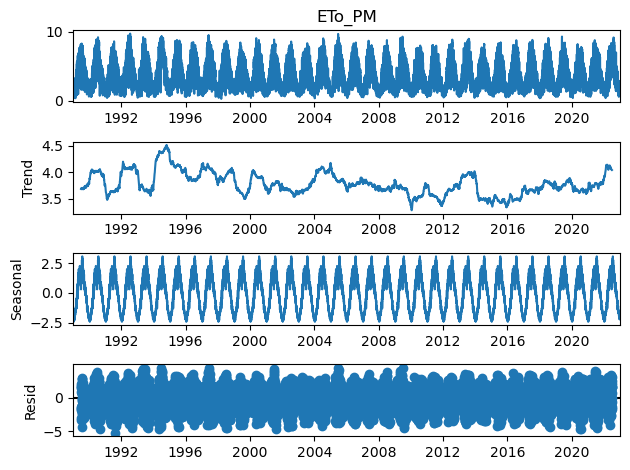

In [5]:
# 对数据进行季节性分解，设置freq为365
et_result = seasonal_decompose(et, model='additive', period=365)

# 绘制分解结果
et_result.plot()
plt.show()

# 获取趋势部分
et_trend = et_result.trend

在使用`seasonal_decompose`函数进行季节性分解时，趋势组件是通过对数据应用移动平均来计算的。移动平均是在每个时间点对其周围的观测值求平均，因此在序列的开始和结束，我们没有足够的观测值来计算移动平均。这就是为什么你在趋势组件中看到了NaN值。

具体来说，如果你设置的`period`参数为365，那么在序列的开始和结束，大约会有365/2=182.5，即约183个观测点是NaN值。这是因为在这些点，我们没有足够的数据来计算完整的一年的移动平均。

如果你想要避免这种情况，你可以选择一个更小的`period`值，但这可能会捕捉到更高频率的季节性。另一种选择是对数据进行插值或填充，以填补这些缺失的趋势值，但这可能会引入一些偏差。

所以时间尺度选择1990到2020年作为研究年份

In [6]:
fengqiao['discharge_trend'] = discharge_trend
fengqiao['precipitation_trend'] = precipitation_trend
mete['et_trend'] = et_trend

In [7]:
# Calculate the detrended parts
fengqiao['discharge_detrended'] = fengqiao['discharge'] - fengqiao['discharge_trend']
fengqiao['precipitation_detrended'] = fengqiao['precipitation'] - fengqiao['precipitation_trend']
mete['et_detrended'] = mete['ETo_PM'] - mete['et_trend']

# Save the detrended parts
fengqiao.to_csv('../data/intermediate/fengqiao_trend.csv')
mete.to_csv('../data/intermediate/mete_trend.csv')

通过趋势性观察三个变量的变化趋势，可以发现，蒸散发量呈现出逐年减少的趋势，而径流量则呈现出逐年增加的趋势。这与城市化的发展趋势是一致的。

而降水量的变化趋势呈现出大周期性质的变化，这与地球运转导致的气候变化有关。

因此，我们可以认为，城市化的发展是导致蒸散发量减少，径流量增加的主要原因。

在模型的搭建过程中，discharge的趋势（这部分主要是城市化导致的地形地貌变化，进而影响地下水的分布）采用机器学习模型解决，discharge的季节性变化采用水文模型解决（Tank 模型由于采用了长时间序列下统一的模型参数，忽略了年际变化）。

# Discharge trend

最初的分解方法存在负数的情况，可以采用乘法模型进行分解，但是乘法模型要求数据不能为0，因此需要对数据进行平移，使其不为0。

在进行季节性分解时，如果你的数据中存在负数，那么你可能需要使用乘法模型而不是加法模型。乘法模型适用于季节性变化随着时间的推移而变大或变小的情况。在乘法模型中，季节性分量是通过乘法而不是加法与趋势-周期分量结合的。

## 乘法模型

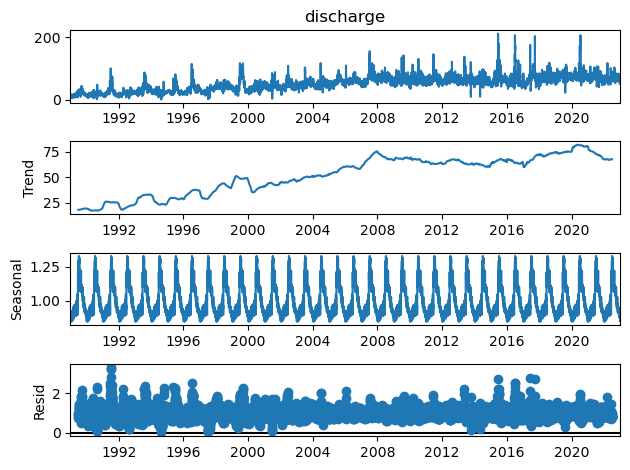

In [11]:
# 对数据进行季节性分解，设置freq为365
discharge_result = seasonal_decompose(discharge, model='multiplicative', period=365)

# 绘制分解结果
discharge_result.plot()
plt.show()

# 获取趋势部分
discharge_trend = discharge_result.trend

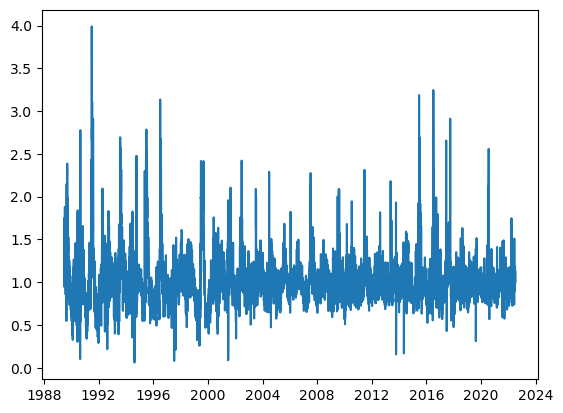

In [12]:
discharge_detrended = discharge / discharge_trend
plt.plot(discharge_detrended)

## 加法模型

乘法模型处理后，数据没有了baseflow和surface runoff的分离，而是变成了一个整体，这样就不能再使用tank model了。

如果你的数据不应该有负数（例如，如果它表示一种不能为负的量，如降雨量或人口数量），那么你可能需要对你的数据进行一些预处理，以确保去趋势化后的数据仍然有意义。

一种可能的方法是对你的数据进行对数变换，然后进行季节性分解。对数变换可以使你的数据的分布更接近正态分布，这可能有助于改善季节性分解的结果。然后，你可以对去趋势化后的数据进行反对数变换，以恢复它的原始尺度。

In [19]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0, parse_dates=True)
discharge = fengqiao['discharge']
# 对数据进行对数变换
discharge_log = np.log(discharge)

# 对变换后的数据进行季节性分解
discharge_result = seasonal_decompose(discharge_log, model='additive', period=365*5)

# 获取趋势部分
discharge_trend = np.exp(discharge_result.trend)

# 计算去趋势化后的数据，并进行反对数变换
discharge_detrended = discharge - discharge_trend

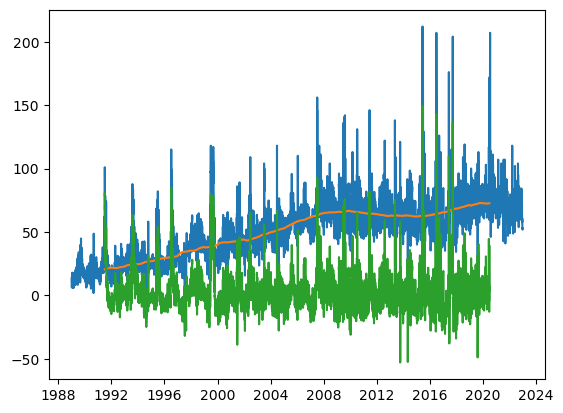

In [20]:
plt.plot(discharge)
plt.plot(discharge_trend)
plt.plot(discharge_detrended)
plt.show()

需要注意的是，这种方法可能会导致去趋势化的数据在趋势分量接近0的地方变得非常大。如果这在你的数据中是一个问题，你可能需要寻找其他的去趋势化方法，例如在进行季节性分解之前对数据进行对数变换。

从discharge_detrend 的图片来看，discharge的均值保持在了一个相对平衡的情况，这和模型期望的数据一致，接下来使用模型进行校验调参。

In [6]:
fengqiao['discharge_trend'] = discharge_trend
fengqiao['discharge_detrended'] = discharge_detrended
fengqiao.to_csv('../data/intermediate/fengqiao_trend.csv')

# Tank model 

In [6]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_trend.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
precipitation = fengqiao['precipitation']
discharge = fengqiao['discharge']
et = mete['ETo_PM']
impervious_area = pd.read_csv('../data/intermediate/Urban_Impervious_Area.csv', index_col=0)

In [4]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_trend.csv', index_col=0, parse_dates=True)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
precipitation = fengqiao['precipitation']
discharge = fengqiao['discharge_detrended']
et = mete['ETo_PM']
impervious_area = pd.read_csv('../data/intermediate/Urban_Impervious_Area.csv', index_col=0)

|   iter    |  target   |     A     |    k1     |    k2     |    k3     |    kc     |
-------------------------------------------------------------------------------------
| 1         | -3.464e+0 | 1.539e+03 | 0.4602    | 0.1       | 0.1581    | 0.744     |
| 2         | -2.479e+0 | 340.7     | 0.1931    | 0.2382    | 0.2044    | 0.8616    |
| 3         | -4.577e+0 | 1.547e+03 | 0.4426    | 0.1818    | 0.4403    | 0.7082    |
| 4         | -5.219e+0 | 2.474e+03 | 0.3087    | 0.3235    | 0.07879   | 0.7594    |
| 5         | -1.68e+04 | 2.955e+03 | 0.5841    | 0.2254    | 0.3492    | 0.9629    |
| 6         | -5.718e+0 | 3.301e+03 | 0.1425    | 0.1156    | 0.09322   | 0.9634    |
| 7         | -2.397e+0 | 362.9     | 0.3106    | 0.4832    | 0.2713    | 0.9076    |
| 8         | -1.681e+0 | 1.164e+03 | 0.4433    | 0.4339    | 0.01896   | 0.925     |
| 9         | -2.611e+0 | 3.649e+03 | 0.4741    | 0.2122    | 0.3967    | 0.731     |
| 10        | -4.402e+0 | 1.653e+03 | 0.5543    | 0.21

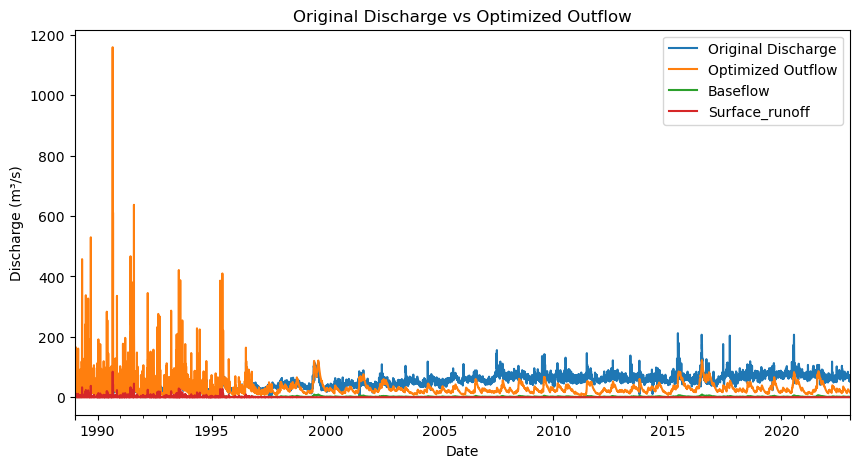

In [7]:
# Define the bounds of the parameters as a list of tuples
param_bounds = {
    'kc': (0.7, 1),
    'k1': (0.1, 0.6),
    'k2': (0.1, 0.5),
    'k3': (0.01, 0.5),
    'A': (0, 3690),
}

def model_error(params):
    kc, k1, k2, k3, A = params['kc'], params['k1'], params['k2'], params['k3'], params['A']
    _, _, outflow = tank_model(precipitation, et, k1, k2, k3, A, kc, impervious_area=impervious_area)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # For BayesianOptimization, we maximize the function. Therefore, use negative MSE.

optimizer = BayesianOptimization(
    lambda k1, k2, k3, A, kc: model_error({'k1': k1, 'k2': k2, 'k3': k3, 'A': A, 'kc': kc}),
    pbounds=param_bounds,
    random_state=1,
)

optimizer.maximize(
    init_points=10,
    n_iter=50,
)

best_params = optimizer.max['params']

if best_params is not None:
    kc_opt = best_params['kc']
    k1_opt = best_params['k1']
    k2_opt = best_params['k2']
    k3_opt = best_params['k3']
    A_opt = best_params['A']
else:
    # Handle the case where no optimal parameters were found
    kc_opt = 0.5
    k1_opt = 0.1
    k2_opt = 0.1
    k3_opt = 0.1
    A_opt = 1000
surface_runoff_opt,baseflow_opt, outflow_opt = tank_model(precipitation, et, k1_opt, k2_opt,k3_opt, A_opt, kc_opt, impervious_area=impervious_area)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Surface_runoff': surface_runoff_opt, 'Baseflow': baseflow_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(discharge, tank_results_opt['Outflow'])

print(tank_results_opt)
## Error
# 均方误差 (Mean Squared Error, MSE)

mse = mean_squared_error(discharge, tank_results_opt['Outflow'])
print('MSE: ', mse)

# 均方根误差 (Root Mean Squared Error, RMSE)

rmse = mean_squared_error(discharge, tank_results_opt['Outflow'], squared=False)
print('RMSE: ', rmse)

# 平均绝对误差 (Mean Absolute Error, MAE)

mae = mean_absolute_error(discharge, tank_results_opt['Outflow'])
print('MAE: ', mae)

# 决定系数 (Coefficient of Determination, R2)

r2 = r2_score(discharge, tank_results_opt['Outflow'])
print('R2: ', r2)
## Figure
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制原始的discharge数据
discharge.plot(ax=ax, label='Original Discharge')

# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')
tank_results_opt['Baseflow'].plot(ax=ax, label='Baseflow')
tank_results_opt['Surface_runoff'].plot(ax=ax, label='Surface_runoff')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()